# Backtesting Framework for StockPredictionPro

This notebook implements a backtesting framework to evaluate trading strategies based on model predictions against historical stock price data.

Key features include:
- Handling historical price and trade data
- Simulated order execution and portfolio management
- Performance tracking metrics such as returns, drawdown, and Sharpe ratio
- Visualization of backtesting results

The framework is essential for validating the real-world effectiveness of predictive models.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
%matplotlib inline

warnings.filterwarnings('ignore')

print('✅ Libraries loaded for backtesting framework')
print('📊 Ready for trading strategy evaluation')


✅ Libraries loaded for backtesting framework
📊 Ready for trading strategy evaluation


In [2]:
# Load historical price data and model predictions
try:
    price_df = pd.read_csv('../data/raw/price_data.csv', parse_dates=['date'], index_col='date')
    preds_df = pd.read_csv('../data/processed/model_predictions.csv', parse_dates=['date'], index_col='date')
    print('✅ Price and prediction data loaded')
    print(f'   • Price data shape: {price_df.shape}')
    print(f'   • Predictions shape: {preds_df.shape}')
except FileNotFoundError:
    print('📝 Required data files not found. Generating sample data for demonstration...')
    
    # Generate realistic sample data
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', periods=500, freq='D')
    
    # Simulate stock prices with realistic movements
    initial_price = 100
    returns = np.random.normal(0.001, 0.02, len(dates))  # 0.1% daily return, 2% volatility
    prices = [initial_price]
    for ret in returns[1:]:
        prices.append(prices[-1] * (1 + ret))
    
    price_df = pd.DataFrame({
        'open': prices,
        'high': np.array(prices) * (1 + np.random.uniform(0, 0.02, len(prices))),
        'low': np.array(prices) * (1 - np.random.uniform(0, 0.02, len(prices))),
        'close': prices,
        'volume': np.random.lognormal(15, 0.5, len(prices))
    }, index=dates)
    
    # Generate sample prediction signals
    # 1: Buy, -1: Sell, 0: Hold
    signals = np.random.choice([-1, 0, 1], size=len(dates), p=[0.3, 0.4, 0.3])
    preds_df = pd.DataFrame({
        'signal': signals,
        'confidence': np.random.uniform(0.5, 1.0, len(dates))
    }, index=dates)
    
    print('✅ Sample data generated for backtesting')

print('\n📋 Price Data Preview:')
display(price_df.head())
print('\n📋 Predictions Preview:')
display(preds_df.head())


📝 Required data files not found. Generating sample data for demonstration...
✅ Sample data generated for backtesting

📋 Price Data Preview:


,open,high,low,close,volume
2020-01-01,100.000000,101.291834,98.256313,100.000000,1.882887e+06
2020-01-02,99.823471,100.963013,99.765080,99.823471,1.114097e+06
2020-01-03,101.216385,101.937242,99.544662,101.216385,3.970050e+06
2020-01-04,104.400713,106.460571,104.131631,104.400713,1.137012e+07
2020-01-05,104.016198,105.276406,103.319042,104.016198,3.259109e+06



📋 Predictions Preview:


,signal,confidence
2020-01-01,1,0.896298
2020-01-02,0,0.953949
2020-01-03,0,0.971851
2020-01-04,-1,0.980068
2020-01-05,1,0.760730


In [3]:
class AdvancedBacktester:
    """
    Professional backtesting framework for trading strategies
    """
    def __init__(self, price_data, prediction_data, initial_capital=100000, 
                 commission=0.001, position_size=0.1):
        """
        Initialize backtester
        
        Args:
            price_data: DataFrame with OHLCV data
            prediction_data: DataFrame with trading signals
            initial_capital: Starting capital in USD
            commission: Transaction cost (e.g., 0.001 = 0.1%)
            position_size: Fraction of capital to use per trade
        """
        self.price_data = price_data
        self.prediction_data = prediction_data
        self.initial_capital = initial_capital
        self.commission = commission
        self.position_size = position_size
        
        # Initialize portfolio tracking
        self.cash = initial_capital
        self.position = 0
        self.portfolio_value = []
        self.trades = []
        self.metrics = {}
        
        print(f"✅ Backtester initialized")
        print(f"   • Initial capital: ${initial_capital:,.2f}")
        print(f"   • Commission: {commission*100:.3f}%")
        print(f"   • Position size: {position_size*100:.1f}%")
    
    def execute_trade(self, date, signal, price):
        """Execute a trade based on signal"""
        if signal == 1 and self.position == 0:  # Buy signal, not already long
            # Calculate shares to buy
            trade_amount = self.cash * self.position_size
            shares = int(trade_amount // price)
            cost = shares * price * (1 + self.commission)
            
            if cost <= self.cash:
                self.cash -= cost
                self.position = shares
                self.trades.append({
                    'date': date,
                    'action': 'BUY',
                    'shares': shares,
                    'price': price,
                    'value': shares * price,
                    'commission': shares * price * self.commission
                })
                
        elif signal == -1 and self.position > 0:  # Sell signal, currently long
            # Sell all shares
            proceeds = self.position * price * (1 - self.commission)
            self.cash += proceeds
            self.trades.append({
                'date': date,
                'action': 'SELL',
                'shares': self.position,
                'price': price,
                'value': self.position * price,
                'commission': self.position * price * self.commission
            })
            self.position = 0
    
    def run_backtest(self):
        """Execute the full backtesting simulation"""
        print("🚀 Running backtest simulation...")
        
        # Ensure data is aligned
        common_dates = self.price_data.index.intersection(self.prediction_data.index)
        print(f"   • Trading days: {len(common_dates)}")
        
        for date in common_dates:
            price = self.price_data.loc[date, 'close']
            signal = self.prediction_data.loc[date, 'signal']
            
            # Execute trade if signal present
            self.execute_trade(date, signal, price)
            
            # Calculate current portfolio value
            portfolio_val = self.cash + (self.position * price)
            self.portfolio_value.append({
                'date': date,
                'cash': self.cash,
                'position_value': self.position * price,
                'total_value': portfolio_val,
                'shares_held': self.position
            })
        
        # Convert to DataFrames
        self.portfolio_df = pd.DataFrame(self.portfolio_value).set_index('date')
        self.trades_df = pd.DataFrame(self.trades)
        if not self.trades_df.empty:
            self.trades_df = self.trades_df.set_index('date')
        
        print(f"✅ Backtest completed")
        print(f"   • Total trades executed: {len(self.trades)}")
        print(f"   • Final portfolio value: ${self.portfolio_df['total_value'].iloc[-1]:,.2f}")
    
    def calculate_metrics(self):
        """Calculate comprehensive performance metrics"""
        if self.portfolio_df.empty:
            print("❌ No portfolio data available. Run backtest first.")
            return {}
        
        # Basic performance metrics
        final_value = self.portfolio_df['total_value'].iloc[-1]
        total_return = (final_value - self.initial_capital) / self.initial_capital
        
        # Daily returns
        daily_returns = self.portfolio_df['total_value'].pct_change().dropna()
        
        # Risk metrics
        volatility = daily_returns.std() * np.sqrt(252)  # Annualized
        sharpe_ratio = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))
        
        # Drawdown analysis
        cumulative_returns = (1 + daily_returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        # Win rate (if trades available)
        win_rate = 0
        if not self.trades_df.empty and len(self.trades_df) >= 2:
            # Simple win rate calculation based on consecutive buy/sell pairs
            buy_trades = self.trades_df[self.trades_df['action'] == 'BUY']
            sell_trades = self.trades_df[self.trades_df['action'] == 'SELL']
            if len(buy_trades) > 0 and len(sell_trades) > 0:
                wins = sum(sell_trades['price'].iloc[i] > buy_trades['price'].iloc[i] 
                          for i in range(min(len(buy_trades), len(sell_trades))))
                win_rate = wins / min(len(buy_trades), len(sell_trades))
        
        self.metrics = {
            'Final Portfolio Value': final_value,
            'Total Return': total_return,
            'Annualized Return': (1 + total_return) ** (252 / len(daily_returns)) - 1,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Maximum Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'Total Trades': len(self.trades),
            'Days Traded': len(self.portfolio_df)
        }
        
        return self.metrics
    
    def plot_performance(self):
        """Create comprehensive performance visualizations"""
        if self.portfolio_df.empty:
            print("❌ No data to plot. Run backtest first.")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Backtesting Results - StockPredictionPro', fontsize=16, fontweight='bold')
        
        # 1. Portfolio Value vs Stock Price
        ax1 = axes[0, 0]
        ax1_twin = ax1.twinx()
        
        ax1.plot(self.portfolio_df.index, self.portfolio_df['total_value'], 
                label='Portfolio Value', color='green', linewidth=2)
        ax1_twin.plot(self.price_data.index, self.price_data['close'], 
                     label='Stock Price', color='blue', alpha=0.7)
        
        ax1.set_ylabel('Portfolio Value ($)', color='green')
        ax1_twin.set_ylabel('Stock Price ($)', color='blue')
        ax1.set_title('Portfolio Performance vs Stock Price')
        ax1.legend(loc='upper left')
        ax1_twin.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        
        # 2. Drawdown Analysis
        ax2 = axes[0, 1]
        daily_returns = self.portfolio_df['total_value'].pct_change().dropna()
        cumulative_returns = (1 + daily_returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        
        ax2.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
        ax2.plot(drawdown.index, drawdown, color='red', linewidth=1)
        ax2.set_ylabel('Drawdown')
        ax2.set_title(f'Drawdown Analysis (Max: {drawdown.min():.2%})')
        ax2.grid(True, alpha=0.3)
        
        # 3. Trade Distribution
        ax3 = axes[1, 0]
        if not self.trades_df.empty:
            buy_trades = self.trades_df[self.trades_df['action'] == 'BUY']
            sell_trades = self.trades_df[self.trades_df['action'] == 'SELL']
            
            ax3.scatter(buy_trades.index, buy_trades['price'], 
                       marker='^', color='green', s=50, label='Buy', alpha=0.7)
            ax3.scatter(sell_trades.index, sell_trades['price'], 
                       marker='v', color='red', s=50, label='Sell', alpha=0.7)
            ax3.plot(self.price_data.index, self.price_data['close'], 
                    color='blue', alpha=0.5, linewidth=1)
            ax3.set_ylabel('Price ($)')
            ax3.set_title('Trading Activity')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'No trades executed', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Trading Activity')
        
        # 4. Returns Distribution
        ax4 = axes[1, 1]
        daily_returns_pct = daily_returns * 100  # Convert to percentage
        ax4.hist(daily_returns_pct, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax4.axvline(daily_returns_pct.mean(), color='red', linestyle='--', 
                   label=f'Mean: {daily_returns_pct.mean():.2f}%')
        ax4.set_xlabel('Daily Returns (%)')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Daily Returns Distribution')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        """Print comprehensive performance summary"""
        if not self.metrics:
            self.calculate_metrics()
        
        print("=" * 60)
        print("BACKTESTING PERFORMANCE SUMMARY")
        print("=" * 60)
        
        print(f"💰 PORTFOLIO PERFORMANCE:")
        print(f"   • Initial Capital:      ${self.initial_capital:,.2f}")
        print(f"   • Final Value:          ${self.metrics['Final Portfolio Value']:,.2f}")
        print(f"   • Total Return:         {self.metrics['Total Return']:.2%}")
        print(f"   • Annualized Return:    {self.metrics['Annualized Return']:.2%}")
        
        print(f"\n📊 RISK METRICS:")
        print(f"   • Volatility:           {self.metrics['Volatility']:.2%}")
        print(f"   • Sharpe Ratio:         {self.metrics['Sharpe Ratio']:.3f}")
        print(f"   • Maximum Drawdown:     {self.metrics['Maximum Drawdown']:.2%}")
        
        print(f"\n📈 TRADING STATISTICS:")
        print(f"   • Total Trades:         {self.metrics['Total Trades']}")
        print(f"   • Win Rate:             {self.metrics['Win Rate']:.2%}")
        print(f"   • Days Traded:          {self.metrics['Days Traded']}")
        
        # Benchmark comparison (simple buy-and-hold)
        initial_price = self.price_data['close'].iloc[0]
        final_price = self.price_data['close'].iloc[-1]
        buy_hold_return = (final_price - initial_price) / initial_price
        
        print(f"\n📊 BENCHMARK COMPARISON:")
        print(f"   • Buy & Hold Return:    {buy_hold_return:.2%}")
        print(f"   • Strategy Outperformance: {(self.metrics['Total Return'] - buy_hold_return):.2%}")

print("✅ Advanced Backtesting Framework initialized")
print("   Ready for comprehensive trading strategy evaluation")


✅ Advanced Backtesting Framework initialized
   Ready for comprehensive trading strategy evaluation


In [4]:
# Initialize and run backtester
print("🎯 Initializing Backtesting Framework...")

backtester = AdvancedBacktester(
    price_data=price_df,
    prediction_data=preds_df,
    initial_capital=100000,
    commission=0.001,  # 0.1% commission
    position_size=0.2   # Use 20% of capital per trade
)

# Run the backtest
backtester.run_backtest()

# Calculate and display performance metrics
metrics = backtester.calculate_metrics()

# Print comprehensive summary
backtester.print_summary()


🎯 Initializing Backtesting Framework...
✅ Backtester initialized
   • Initial capital: $100,000.00
   • Commission: 0.100%
   • Position size: 20.0%
🚀 Running backtest simulation...
   • Trading days: 500
✅ Backtest completed
   • Total trades executed: 146
   • Final portfolio value: $95,769.37
BACKTESTING PERFORMANCE SUMMARY
💰 PORTFOLIO PERFORMANCE:
   • Initial Capital:      $100,000.00
   • Final Value:          $95,769.37
   • Total Return:         -4.23%
   • Annualized Return:    -2.16%

📊 RISK METRICS:
   • Volatility:           4.56%
   • Sharpe Ratio:         -0.453
   • Maximum Drawdown:     -5.91%

📈 TRADING STATISTICS:
   • Total Trades:         146
   • Win Rate:             45.21%
   • Days Traded:          500

📊 BENCHMARK COMPARISON:
   • Buy & Hold Return:    58.64%
   • Strategy Outperformance: -62.87%


📊 Generating performance visualizations...


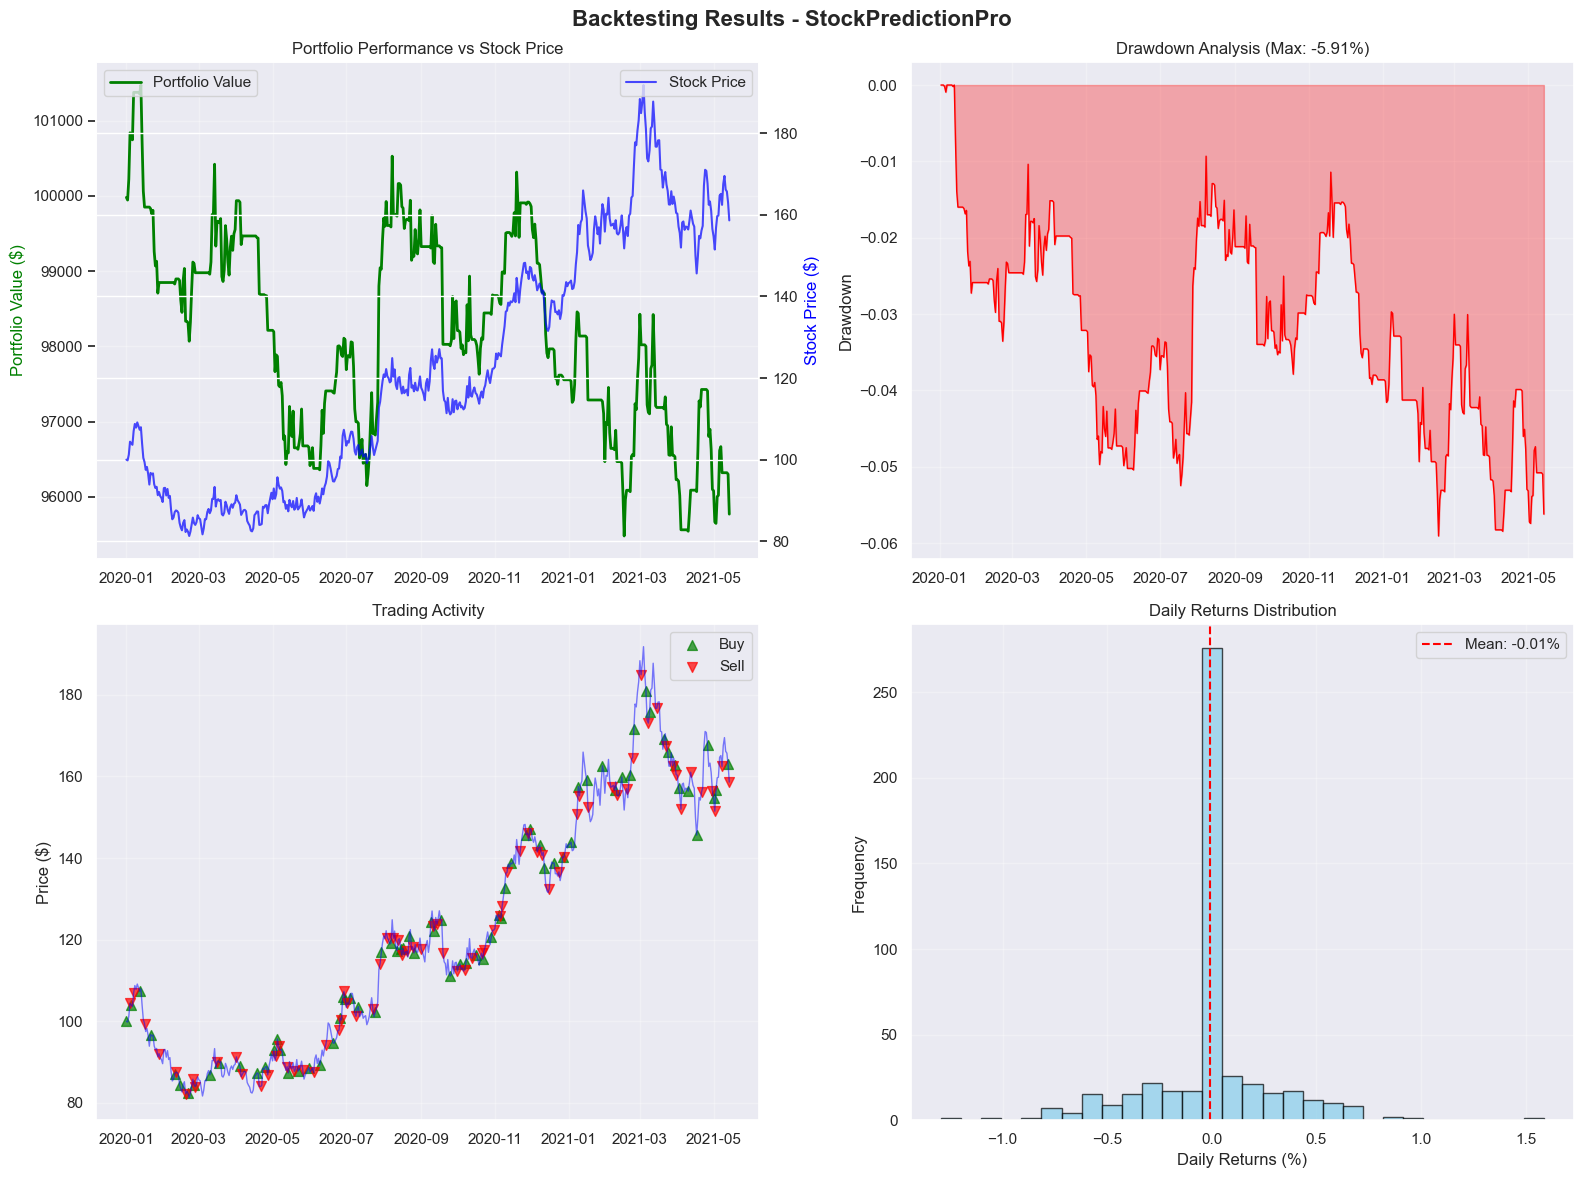


📋 Recent Trades:


,action,shares,price,value,commission
date,,,,,
2021-04-17,BUY,131,145.640718,19078.934088,19.078934
2021-04-21,SELL,131,156.161106,20457.104895,20.457105
2021-04-26,BUY,116,167.682218,19451.137291,19.451137
2021-04-30,SELL,116,156.561185,18161.097457,18.161097
2021-05-01,BUY,124,154.693182,19181.954546,19.181955
2021-05-02,SELL,124,151.501713,18786.212408,18.786212
2021-05-03,BUY,122,156.765312,19125.368019,19.125368
2021-05-08,SELL,122,162.451065,19819.029971,19.819030
2021-05-13,BUY,118,162.985377,19232.274495,19.232274



💼 Trading Summary:
   • Buy orders: 73
   • Sell orders: 73
   • Average buy price: $123.76
   • Average sell price: $123.55
   • Total commission paid: $2856.91

✅ Backtesting analysis completed!


In [5]:
# Generate comprehensive performance plots
print("📊 Generating performance visualizations...")

backtester.plot_performance()

# Additional analysis: Trade details
if not backtester.trades_df.empty:
    print("\n📋 Recent Trades:")
    display(backtester.trades_df.tail(10))
    
    print(f"\n💼 Trading Summary:")
    buy_trades = backtester.trades_df[backtester.trades_df['action'] == 'BUY']
    sell_trades = backtester.trades_df[backtester.trades_df['action'] == 'SELL']
    
    print(f"   • Buy orders: {len(buy_trades)}")
    print(f"   • Sell orders: {len(sell_trades)}")
    print(f"   • Average buy price: ${buy_trades['price'].mean():.2f}" if len(buy_trades) > 0 else "   • No buy orders")
    print(f"   • Average sell price: ${sell_trades['price'].mean():.2f}" if len(sell_trades) > 0 else "   • No sell orders")
    print(f"   • Total commission paid: ${backtester.trades_df['commission'].sum():.2f}")

print("\n✅ Backtesting analysis completed!")
